# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 4947 × 52 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

Fitting estimator with 52 features.
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 4 of 100
building tree 1 of 100
building tree 14 of 100building tree 10 of 100

building tree 6 of 100
building tree 8 of 100
building tree 13 of 100
building tree 9 of 100
building tree 12 of 100
building tree 24 of 100
building tree 20 of 100
building tree 11 of 100building tree 25 of 100
building tree 21 of 100
building tree 18 of 100
building tree 16 of 100

building tree 19 of 100
building tree 7 of 100
building tree 15 of 100
building tree 22 of 100
building tree 28 of 100
building tree 17 of 100
building tree 27 of 100
building tree 23 of 100
building tree 26 of 100
building tree 30 of 100
building tree 29 of 100
building tree 32 of 100
building tree 35 of 100building tree 37 of 100
building tree 33 of 100



[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 36 of 100building tree 34 of 100

building tree 31 of 100building tree 38 of 100

building tree 44 of 100building tree 40 of 100
building tree 39 of 100

building tree 43 of 100building tree 42 of 100

building tree 41 of 100building tree 46 of 100
building tree 45 of 100

building tree 47 of 100building tree 51 of 100

building tree 55 of 100
building tree 53 of 100
building tree 56 of 100building tree 54 of 100
building tree 48 of 100building tree 50 of 100


building tree 57 of 100
building tree 49 of 100building tree 60 of 100building tree 59 of 100


building tree 52 of 100building tree 58 of 100

building tree 62 of 100
building tree 61 of 100
building tree 64 of 100
building tree 63 of 100
building tree 67 of 100
building tree 66 of 100
building tree 65 of 100building tree 69 of 100

building tree 72 of 100building tree 71 of 100

building tree 75 of 100
building tree 70 of 100
building tree 68 of 100
building tree 80 of 100
building tree 79 of 100building tree 77 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


building tree 97 of 100
building tree 95 of 100
building tree 98 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100
Fitting estimator with 49 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 100
building tree 2 of 100
building tree 4 of 100
building tree 5 of 100
building tree 7 of 100
building tree 1 of 100
building tree 10 of 100
building tree 11 of 100
building tree 14 of 100
building tree 9 of 100
building tree 13 of 100
building tree 15 of 100
building tree 8 of 100
building tree 12 of 100
building tree 19 of 100
building tree 22 of 100
building tree 16 of 100
building tree 25 of 100
building tree 6 of 100
building tree 21 of 100
building tree 23 of 100
building tree 29 of 100
building tree 17 of 100
building tree 27 of 100
building tree 18 of 100
building tree 24 of 100
building tree 30 of 100
building tree 26 of 100
building tree 20 of 100
building tree 28 of 100
building tree 33 of 100
building tree 36 of 100
building tree 31 of 100
building tree 34 of 100building tree 35 of 100

building tree 32 of 100
building tree 37 of 100
building tree 39 of 100
building tree 48 of 100
building tree 38 of 100
building tree 43 of 100
building tree 41 of 100
b

building tree 66 of 100building tree 64 of 100

building tree 72 of 100building tree 69 of 100

building tree 75 of 100building tree 65 of 100building tree 67 of 100


building tree 70 of 100
building tree 68 of 100
building tree 79 of 100
building tree 78 of 100building tree 71 of 100

building tree 74 of 100
building tree 80 of 100
building tree 83 of 100building tree 73 of 100
building tree 90 of 100building tree 84 of 100


building tree 76 of 100building tree 82 of 100building tree 87 of 100


building tree 88 of 100building tree 91 of 100
building tree 77 of 100
building tree 86 of 100

building tree 85 of 100
building tree 89 of 100
building tree 81 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100
building tree 100 of 100
building tree 95 of 100
building tree 98 of 100
building tree 96 of 100
building tree 97 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 46 features.
building tree 1 of 100
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 6 of 100
building tree 9 of 100
building tree 4 of 100
building tree 14 of 100
building tree 12 of 100
building tree 7 of 100
building tree 15 of 100
building tree 20 of 100
building tree 18 of 100
building tree 22 of 100
building tree 16 of 100
building tree 28 of 100
building tree 13 of 100
building tree 8 of 100
building tree 30 of 100
building tree 19 of 100
building tree 21 of 100
building tree 17 of 100
building tree 25 of 100
building tree 11 of 100
building tree 23 of 100
building tree 10 of 100
building tree 24 of 100
building tree 29 of 100
building tree 26 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100
building tree 38 of 100
building tree 36 of 100
building tree 39 of 100
building tree 41 of 100
building tree 35 of 100
building tree 44 of 100
building tree 33 of 100building tree 

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 37 of 100building tree 43 of 100

building tree 48 of 100
building tree 53 of 100
building tree 42 of 100building tree 40 of 100building tree 45 of 100

building tree 50 of 100
building tree 49 of 100

building tree 57 of 100
building tree 51 of 100

building tree 54 of 100building tree 46 of 100
building tree 55 of 100

building tree 52 of 100
building tree 56 of 100
building tree 59 of 100
building tree 58 of 100
building tree 61 of 100
building tree 63 of 100building tree 67 of 100
building tree 62 of 100building tree 60 of 100

building tree 71 of 100
building tree 66 of 100building tree 65 of 100


building tree 68 of 100building tree 64 of 100

building tree 74 of 100
building tree 72 of 100
building tree 70 of 100building tree 75 of 100building tree 73 of 100


building tree 69 of 100building tree 79 of 100building tree 83 of 100


building tree 80 of 100
building tree 78 of 100building tree 84 of 100building tree 85 of 100
building tree 76 of 100


building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 43 features.
building tree 6 of 100building tree 2 of 100

building tree 9 of 100building tree 17 of 100
building tree 11 of 100
building tree 5 of 100
building tree 12 of 100building tree 3 of 100
building tree 16 of 100
building tree 13 of 100

building tree 8 of 100

building tree 14 of 100
building tree 15 of 100
building tree 7 of 100building tree 4 of 100

building tree 10 of 100
building tree 1 of 100
building tree 18 of 100
building tree 23 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 25 of 100
building tree 26 of 100
building tree 19 of 100
building tree 29 of 100
building tree 28 of 100
building tree 27 of 100
building tree 24 of 100
building tree 22 of 100
building tree 30 of 100
building tree 34 of 100
building tree 35 of 100
building tree 33 of 100
building tree 42 of 100
building tree 40 of 100building tree 37 of 100
building tree 47 of 100building tree 31 of 100
building tree 41 of 100

building tree 36 of 100
building tree 38 of 100

building tree 46 of 100building tree 32 of 100

building tree 44 of 100
building tree 43 of 100
building tree 51 of 100building tree 39 of 100
building tree 50 of 100

building tree 48 of 100
building tree 49 of 100
building tree 45 of 100
building tree 52 of 100building tree 55 of 100

building tree 53 of 100building tree 57 of 100

building tree 56 of 100
building tree 59 of 100building tree 58 of 100
building tree 54 of 100

building tree 60 of 100
building tree 62 of 100
building tree 61 of 100
building tree 63

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


building tree 86 of 100building tree 91 of 100
building tree 84 of 100

building tree 87 of 100
building tree 90 of 100
building tree 89 of 100
building tree 97 of 100building tree 93 of 100building tree 92 of 100
building tree 94 of 100


building tree 95 of 100
building tree 98 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100


Fitting estimator with 40 features.
building tree 4 of 100
building tree 1 of 100
building tree 2 of 100
building tree 8 of 100
building tree 5 of 100
building tree 9 of 100
building tree 3 of 100building tree 11 of 100
building tree 7 of 100

building tree 14 of 100
building tree 13 of 100
building tree 17 of 100
building tree 15 of 100
building tree 10 of 100
building tree 12 of 100
building tree 20 of 100
building tree 23 of 100
building tree 16 of 100building tree 21 of 100

building tree 18 of 100
building tree 19 of 100
building tree 24 of 100
building tree 6 of 100
building tree 22 of 100building tree 27 of 100

building tree 29 of 100
building tree 25 of 100
building tree 26 of 100
building tree 28 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 39 of 100building tree 36 of 100building tree 34 of 100




[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 35 of 100building tree 40 of 100building tree 47 of 100

building tree 37 of 100building tree 42 of 100
building tree 43 of 100

building tree 41 of 100

building tree 44 of 100building tree 46 of 100

building tree 38 of 100
building tree 45 of 100
building tree 53 of 100
building tree 49 of 100
building tree 51 of 100
building tree 48 of 100
building tree 50 of 100
building tree 52 of 100building tree 56 of 100

building tree 57 of 100building tree 55 of 100
building tree 54 of 100

building tree 59 of 100
building tree 58 of 100
building tree 60 of 100
building tree 64 of 100
building tree 62 of 100
building tree 63 of 100
building tree 61 of 100building tree 70 of 100building tree 72 of 100


building tree 66 of 100
building tree 68 of 100
building tree 73 of 100
building tree 65 of 100
building tree 69 of 100
building tree 74 of 100
building tree 71 of 100building tree 67 of 100

building tree 78 of 100
building tree 83 of 100
building tree 82 of 100
building tree 76

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.4s finished


Fitting estimator with 37 features.
building tree 1 of 100building tree 5 of 100
building tree 4 of 100building tree 3 of 100


building tree 2 of 100
building tree 13 of 100
building tree 8 of 100
building tree 7 of 100
building tree 14 of 100
building tree 10 of 100
building tree 6 of 100
building tree 9 of 100
building tree 18 of 100
building tree 24 of 100
building tree 16 of 100
building tree 12 of 100
building tree 26 of 100
building tree 20 of 100
building tree 17 of 100
building tree 23 of 100
building tree 11 of 100
building tree 25 of 100
building tree 27 of 100
building tree 19 of 100
building tree 22 of 100
building tree 21 of 100
building tree 15 of 100
building tree 28 of 100
building tree 30 of 100
building tree 29 of 100
building tree 32 of 100
building tree 31 of 100
building tree 36 of 100
building tree 35 of 100
building tree 34 of 100
building tree 44 of 100
building tree 39 of 100
building tree 37 of 100building tree 33 of 100

building tree 40 of 100building tree 

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 38 of 100


building tree 48 of 100building tree 47 of 100
building tree 46 of 100

building tree 42 of 100
building tree 51 of 100
building tree 55 of 100building tree 49 of 100

building tree 53 of 100
building tree 54 of 100
building tree 59 of 100building tree 58 of 100

building tree 50 of 100
building tree 52 of 100
building tree 56 of 100building tree 60 of 100

building tree 57 of 100
building tree 61 of 100building tree 65 of 100

building tree 62 of 100
building tree 63 of 100
building tree 66 of 100building tree 70 of 100building tree 64 of 100


building tree 67 of 100building tree 69 of 100

building tree 71 of 100
building tree 72 of 100building tree 77 of 100

building tree 75 of 100
building tree 68 of 100building tree 74 of 100

building tree 79 of 100building tree 73 of 100
building tree 78 of 100

building tree 82 of 100building tree 80 of 100
building tree 86 of 100
building tree 76 of 100building tree 81 of 100building tree 85 of 100



building tree 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 34 features.
building tree 2 of 100building tree 3 of 100
building tree 1 of 100

building tree 7 of 100
building tree 5 of 100
building tree 4 of 100
building tree 12 of 100
building tree 17 of 100
building tree 21 of 100
building tree 6 of 100
building tree 8 of 100
building tree 9 of 100
building tree 11 of 100
building tree 13 of 100
building tree 20 of 100
building tree 23 of 100
building tree 24 of 100
building tree 28 of 100
building tree 14 of 100
building tree 25 of 100
building tree 10 of 100
building tree 16 of 100
building tree 29 of 100
building tree 15 of 100
building tree 19 of 100
building tree 18 of 100
building tree 26 of 100
building tree 30 of 100
building tree 22 of 100
building tree 27 of 100
building tree 34 of 100
building tree 31 of 100
building tree 33 of 100building tree 32 of 100

building tree 40 of 100
building tree 35 of 100
building tree 37 of 100
building tree 42 of 100
building tree 43 of 100
building tree 39 of 100
building tree

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.



building tree 50 of 100building tree 41 of 100building tree 44 of 100


building tree 45 of 100building tree 38 of 100building tree 47 of 100
building tree 56 of 100


building tree 48 of 100
building tree 49 of 100building tree 51 of 100

building tree 55 of 100
building tree 58 of 100building tree 54 of 100

building tree 52 of 100
building tree 59 of 100
building tree 53 of 100
building tree 57 of 100
building tree 60 of 100
building tree 62 of 100
building tree 61 of 100
building tree 64 of 100
building tree 65 of 100
building tree 71 of 100building tree 67 of 100

building tree 66 of 100building tree 63 of 100

building tree 70 of 100building tree 69 of 100

building tree 72 of 100
building tree 81 of 100
building tree 79 of 100
building tree 68 of 100
building tree 85 of 100
building tree 73 of 100building tree 78 of 100building tree 84 of 100

building tree 74 of 100

building tree 76 of 100
building tree 75 of 100building tree 87 of 100
building tree 82 of 100

building tree 8

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 31 features.
building tree 2 of 100building tree 3 of 100
building tree 1 of 100

building tree 4 of 100
building tree 7 of 100
building tree 6 of 100
building tree 8 of 100
building tree 5 of 100
building tree 10 of 100
building tree 19 of 100
building tree 21 of 100
building tree 17 of 100
building tree 9 of 100
building tree 12 of 100
building tree 14 of 100
building tree 16 of 100
building tree 13 of 100
building tree 20 of 100
building tree 11 of 100
building tree 15 of 100
building tree 22 of 100
building tree 30 of 100
building tree 23 of 100
building tree 24 of 100
building tree 28 of 100
building tree 26 of 100
building tree 18 of 100
building tree 27 of 100
building tree 29 of 100
building tree 25 of 100
building tree 31 of 100
building tree 33 of 100
building tree 34 of 100
building tree 38 of 100building tree 40 of 100
building tree 32 of 100
building tree 35 of 100
building tree 37 of 100

building tree 36 of 100
building tree 41 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 44 of 100
building tree 52 of 100building tree 48 of 100
building tree 49 of 100
building tree 46 of 100
building tree 39 of 100

building tree 45 of 100building tree 51 of 100

building tree 56 of 100building tree 43 of 100

building tree 53 of 100
building tree 55 of 100
building tree 47 of 100building tree 42 of 100
building tree 58 of 100building tree 50 of 100


building tree 57 of 100
building tree 59 of 100
building tree 60 of 100
building tree 54 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100building tree 61 of 100

building tree 67 of 100
building tree 70 of 100
building tree 66 of 100building tree 71 of 100

building tree 65 of 100building tree 68 of 100

building tree 73 of 100
building tree 75 of 100building tree 69 of 100

building tree 77 of 100building tree 72 of 100

building tree 74 of 100building tree 79 of 100

building tree 80 of 100
building tree 76 of 100
building tree 83 of 100
building tree 81 of 100building tree 87 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 6 of 100
building tree 8 of 100
building tree 1 of 100
building tree 15 of 100
building tree 9 of 100
building tree 18 of 100
building tree 3 of 100
building tree 4 of 100
building tree 20 of 100
building tree 10 of 100
building tree 16 of 100
building tree 17 of 100
building tree 11 of 100
building tree 7 of 100
building tree 12 of 100
building tree 5 of 100
building tree 19 of 100
building tree 14 of 100
building tree 27 of 100
building tree 13 of 100
building tree 25 of 100
building tree 26 of 100
building tree 28 of 100
building tree 22 of 100
building tree 30 of 100
building tree 24 of 100
building tree 23 of 100
building tree 21 of 100
building tree 29 of 100
building tree 39 of 100building tree 31 of 100

building tree 34 of 100building tree 33 of 100
building tree 32 of 100

building tree 35 of 100
building tree 40 of 100
building tree 37 of 100building tree 45 of 100

building tree 44 of 100
building tree 42 of 100building tree 47 of 100bui

building tree 69 of 100
building tree 65 of 100
building tree 67 of 100building tree 63 of 100building tree 71 of 100

building tree 70 of 100

building tree 64 of 100
building tree 76 of 100building tree 74 of 100

building tree 72 of 100building tree 75 of 100building tree 77 of 100


building tree 66 of 100
building tree 78 of 100
building tree 68 of 100
building tree 73 of 100
building tree 80 of 100
building tree 81 of 100
building tree 84 of 100
building tree 83 of 100
building tree 79 of 100building tree 82 of 100

building tree 88 of 100
building tree 85 of 100
building tree 86 of 100building tree 87 of 100

building tree 94 of 100
building tree 90 of 100building tree 89 of 100
building tree 95 of 100

building tree 92 of 100
building tree 93 of 100
building tree 91 of 100
building tree 97 of 100
building tree 99 of 100
building tree 100 of 100
building tree 96 of 100
building tree 98 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 7 of 100
building tree 9 of 100
building tree 16 of 100
building tree 18 of 100
building tree 6 of 100
building tree 10 of 100
building tree 11 of 100
building tree 5 of 100
building tree 4 of 100
building tree 15 of 100
building tree 23 of 100
building tree 13 of 100
building tree 12 of 100
building tree 8 of 100
building tree 17 of 100
building tree 20 of 100
building tree 21 of 100
building tree 30 of 100
building tree 28 of 100
building tree 14 of 100
building tree 27 of 100
building tree 19 of 100
building tree 22 of 100
building tree 24 of 100
building tree 26 of 100
building tree 25 of 100
building tree 29 of 100
building tree 32 of 100
building tree 33 of 100
building tree 31 of 100
building tree 38 of 100
building tree 34 of 100building tree 37 of 100

building tree 35 of 100
building tree 44 of 100building tree 43 of 100

building tree 41 of 100
building tree 36 of 100building tree 42 of 100

b

building tree 65 of 100
building tree 64 of 100
building tree 68 of 100
building tree 67 of 100
building tree 66 of 100
building tree 69 of 100
building tree 72 of 100
building tree 70 of 100building tree 77 of 100

building tree 74 of 100building tree 80 of 100

building tree 71 of 100
building tree 78 of 100building tree 82 of 100

building tree 83 of 100building tree 75 of 100

building tree 79 of 100
building tree 76 of 100building tree 90 of 100

building tree 88 of 100
building tree 86 of 100
building tree 81 of 100building tree 89 of 100

building tree 85 of 100building tree 73 of 100

building tree 84 of 100
building tree 87 of 100
building tree 93 of 100building tree 94 of 100

building tree 95 of 100building tree 92 of 100

building tree 96 of 100
building tree 91 of 100
building tree 97 of 100building tree 100 of 100

building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.3s finished


['Model/RFECV.lib']

## Featurs

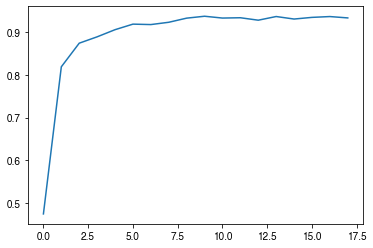

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

28 features selected by RFECV


## Testing

In [15]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [16]:
balanced_accuracy_score(test_label, pred_label)

0.9604794900771229

## Confusion matrix

In [17]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 4)]

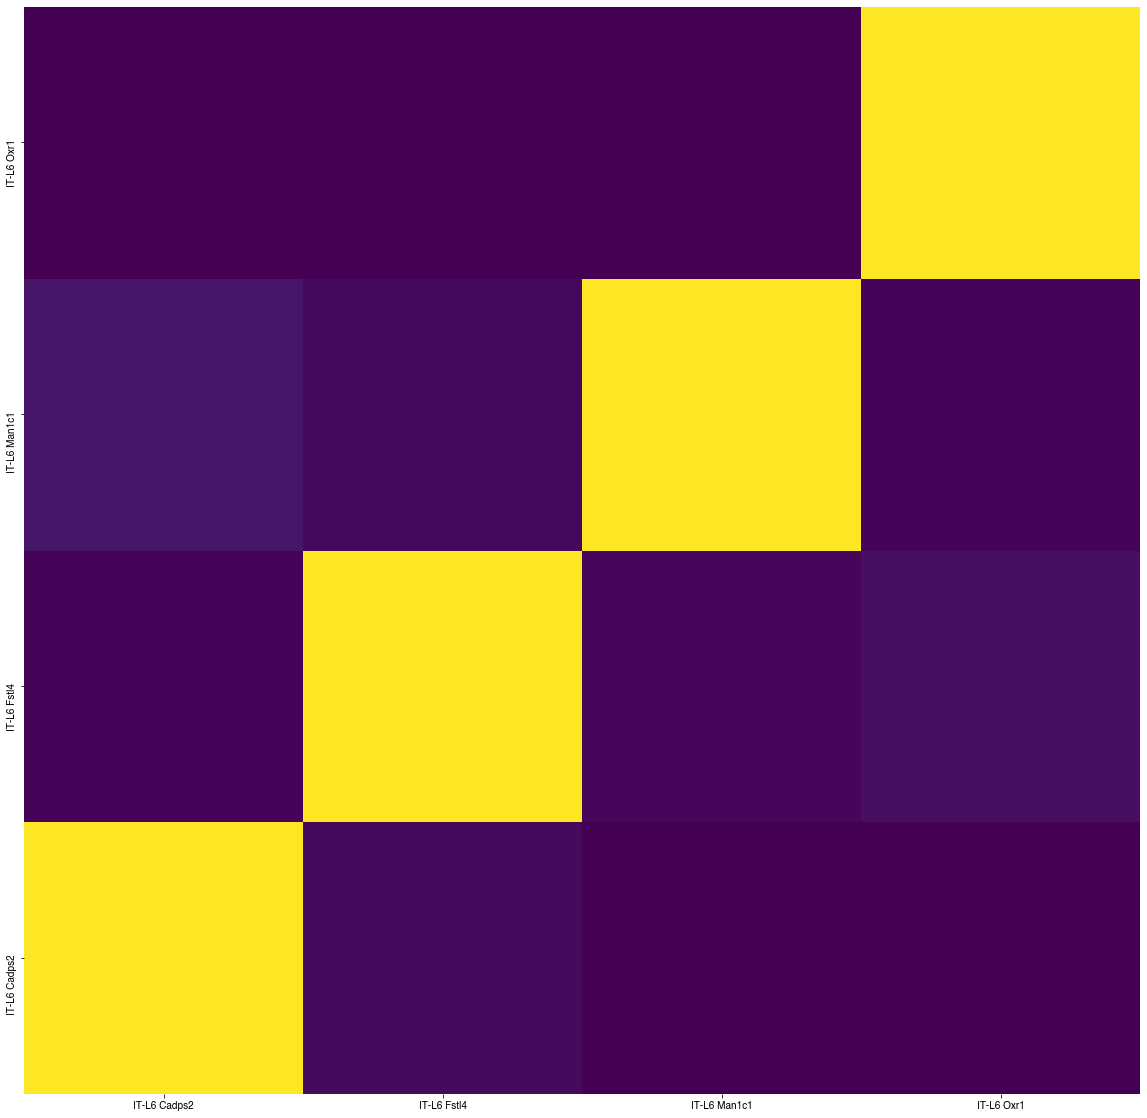

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [19]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

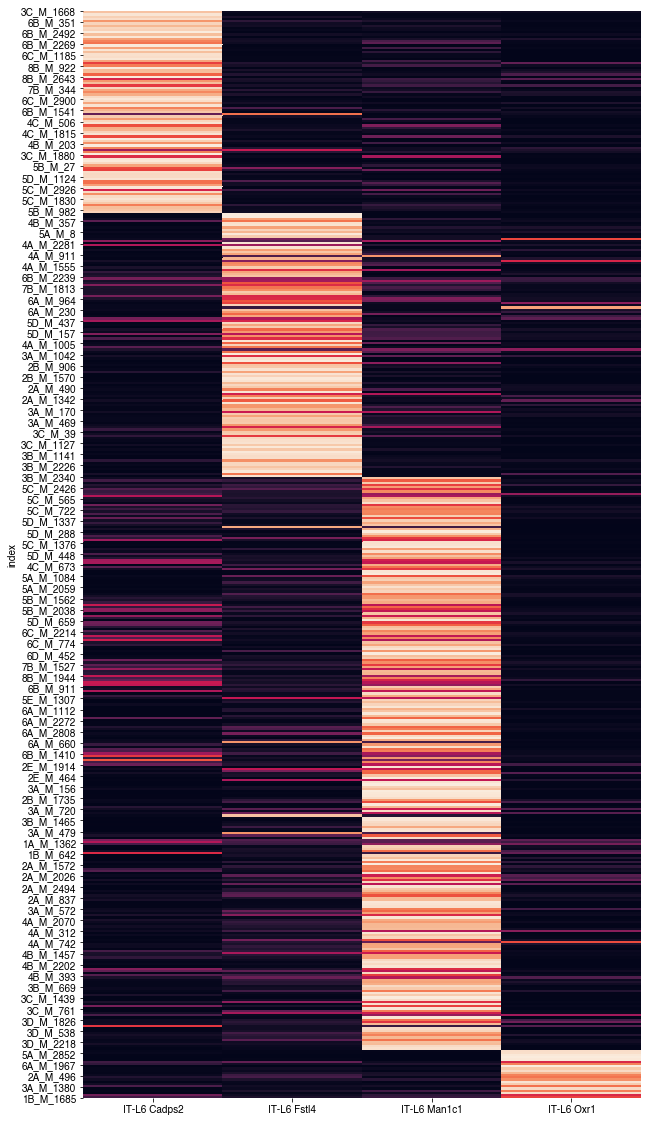

In [20]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

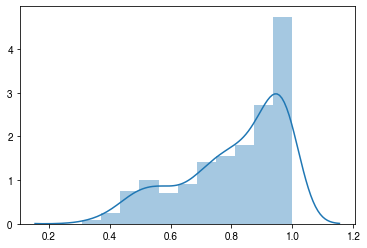

In [21]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [22]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [23]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [24]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 500
building tree 3 of 500
building tree 8 of 500
building tree 2 of 500
building tree 7 of 500
building tree 14 of 500
building tree 9 of 500
building tree 5 of 500
building tree 16 of 500
building tree 4 of 500
building tree 12 of 500
building tree 6 of 500
building tree 13 of 500
building tree 11 of 500
building tree 17 of 500
building tree 18 of 500
building tree 10 of 500
building tree 20 of 500
building tree 15 of 500
building tree 19 of 500
building tree 28 of 500
building tree 26 of 500
building tree 27 of 500
building tree 23 of 500
building tree 22 of 500
building tree 21 of 500
building tree 24 of 500
building tree 25 of 500
building tree 30 of 500
building tree 29 of 500
building tree 31 of 500
building tree 34 of 500building tree 32 of 500
building tree 37 of 500

building tree 40 of 500
building tree 36 of 500building tree 38 of 500

building tree 35 of 500building tree 42 of 500

building tree 33 of 500
building tree 39 of 500
building tree 43 of 500
b

building tree 66 of 500building tree 64 of 500

building tree 67 of 500building tree 74 of 500building tree 68 of 500


building tree 69 of 500
building tree 70 of 500
building tree 78 of 500building tree 65 of 500
building tree 71 of 500

building tree 72 of 500building tree 80 of 500

building tree 75 of 500
building tree 73 of 500
building tree 76 of 500
building tree 81 of 500building tree 82 of 500
building tree 77 of 500
building tree 79 of 500building tree 84 of 500


building tree 88 of 500building tree 85 of 500building tree 89 of 500

building tree 87 of 500

building tree 83 of 500
building tree 91 of 500building tree 93 of 500

building tree 86 of 500
building tree 90 of 500building tree 92 of 500

building tree 94 of 500
building tree 95 of 500building tree 96 of 500

building tree 98 of 500building tree 99 of 500building tree 102 of 500


building tree 97 of 500building tree 104 of 500
building tree 100 of 500

building tree 105 of 500
building tree 103 of 500
building tr

[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.3s


building tree 123 of 500
building tree 122 of 500
building tree 125 of 500
building tree 127 of 500
building tree 126 of 500building tree 129 of 500
building tree 128 of 500
building tree 132 of 500

building tree 131 of 500
building tree 134 of 500
building tree 133 of 500building tree 139 of 500

building tree 136 of 500
building tree 135 of 500building tree 130 of 500

building tree 137 of 500building tree 138 of 500building tree 140 of 500


building tree 141 of 500
building tree 142 of 500building tree 143 of 500
building tree 144 of 500building tree 147 of 500


building tree 148 of 500
building tree 145 of 500
building tree 151 of 500building tree 150 of 500

building tree 146 of 500building tree 152 of 500
building tree 149 of 500
building tree 153 of 500

building tree 157 of 500
building tree 158 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 159 of 500
building tree 164 of 500
building tree 165 of 500building tree 160 of 500
b

building tree 187 of 500
building tree 189 of 500

building tree 185 of 500
building tree 190 of 500
building tree 193 of 500
building tree 196 of 500
building tree 191 of 500building tree 192 of 500
building tree 194 of 500
building tree 201 of 500

building tree 195 of 500building tree 198 of 500

building tree 200 of 500
building tree 197 of 500building tree 203 of 500building tree 202 of 500


building tree 206 of 500building tree 199 of 500

building tree 205 of 500
building tree 204 of 500
building tree 208 of 500
building tree 212 of 500
building tree 211 of 500building tree 209 of 500
building tree 210 of 500

building tree 217 of 500
building tree 214 of 500building tree 207 of 500

building tree 219 of 500building tree 213 of 500

building tree 218 of 500
building tree 220 of 500
building tree 216 of 500
building tree 215 of 500
building tree 223 of 500
building tree 225 of 500
building tree 221 of 500building tree 222 of 500
building tree 226 of 500

building tree 232 of 500


building tree 245 of 500
building tree 247 of 500
building tree 253 of 500building tree 248 of 500

building tree 246 of 500
building tree 251 of 500
building tree 250 of 500building tree 249 of 500

building tree 256 of 500
building tree 255 of 500
building tree 258 of 500
building tree 252 of 500
building tree 257 of 500building tree 254 of 500building tree 259 of 500


building tree 261 of 500
building tree 262 of 500
building tree 260 of 500
building tree 264 of 500
building tree 263 of 500
building tree 267 of 500
building tree 265 of 500
building tree 266 of 500
building tree 269 of 500building tree 271 of 500building tree 273 of 500
building tree 272 of 500


building tree 270 of 500
building tree 268 of 500building tree 278 of 500

building tree 274 of 500
building tree 275 of 500
building tree 283 of 500
building tree 280 of 500
building tree 281 of 500
building tree 277 of 500
building tree 287 of 500
building tree 279 of 500
building tree 285 of 500building tree 276 of 500


[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.8s


building tree 310 of 500building tree 306 of 500

building tree 307 of 500
building tree 305 of 500
building tree 309 of 500building tree 308 of 500

building tree 311 of 500
building tree 312 of 500building tree 316 of 500
building tree 313 of 500

building tree 317 of 500building tree 320 of 500

building tree 314 of 500
building tree 321 of 500
building tree 325 of 500
building tree 315 of 500
building tree 323 of 500building tree 324 of 500building tree 318 of 500


building tree 326 of 500
building tree 327 of 500
building tree 331 of 500building tree 322 of 500

building tree 332 of 500
building tree 333 of 500
building tree 319 of 500building tree 328 of 500

building tree 329 of 500
building tree 330 of 500
building tree 335 of 500building tree 339 of 500building tree 334 of 500


building tree 338 of 500building tree 341 of 500

building tree 336 of 500
building tree 340 of 500
building tree 342 of 500
building tree 337 of 500
building tree 344 of 500
building tree 347 of 500


building tree 367 of 500building tree 365 of 500

building tree 364 of 500
building tree 370 of 500
building tree 373 of 500
building tree 366 of 500
building tree 378 of 500
building tree 372 of 500
building tree 371 of 500
building tree 374 of 500
building tree 375 of 500building tree 379 of 500

building tree 382 of 500
building tree 376 of 500
building tree 383 of 500building tree 380 of 500
building tree 381 of 500

building tree 385 of 500
building tree 377 of 500
building tree 384 of 500
building tree 386 of 500building tree 389 of 500

building tree 387 of 500
building tree 392 of 500
building tree 398 of 500building tree 390 of 500
building tree 388 of 500

building tree 391 of 500
building tree 394 of 500building tree 396 of 500

building tree 397 of 500
building tree 395 of 500building tree 393 of 500

building tree 400 of 500
building tree 399 of 500
building tree 404 of 500
building tree 402 of 500
building tree 403 of 500
building tree 409 of 500
building tree 408 of 500


building tree 424 of 500
building tree 423 of 500
building tree 428 of 500building tree 435 of 500building tree 432 of 500building tree 429 of 500



building tree 434 of 500building tree 426 of 500
building tree 431 of 500
building tree 433 of 500

building tree 438 of 500
building tree 436 of 500
building tree 439 of 500
building tree 441 of 500building tree 437 of 500

building tree 442 of 500
building tree 440 of 500
building tree 444 of 500building tree 443 of 500

building tree 445 of 500
building tree 447 of 500building tree 451 of 500

building tree 448 of 500building tree 449 of 500

building tree 454 of 500
building tree 455 of 500building tree 446 of 500

building tree 450 of 500building tree 453 of 500
building tree 452 of 500

building tree 465 of 500
building tree 461 of 500
building tree 460 of 500
building tree 462 of 500building tree 459 of 500
building tree 464 of 500building tree 457 of 500


building tree 463 of 500
building tree 456 of 500building tree 466 of 500



building tree 491 of 500
building tree 495 of 500
building tree 487 of 500building tree 498 of 500
building tree 493 of 500
building tree 497 of 500
building tree 496 of 500

building tree 494 of 500
building tree 488 of 500
building tree 492 of 500
building tree 500 of 500
building tree 499 of 500


[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    1.7s finished


['Model/FinalClassifier.lib']

## Final Pred

In [25]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


In [26]:
balanced_accuracy_score(test_label, final_pred_label)

0.9585415055809988

## Final evaluate

In [27]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 4)]

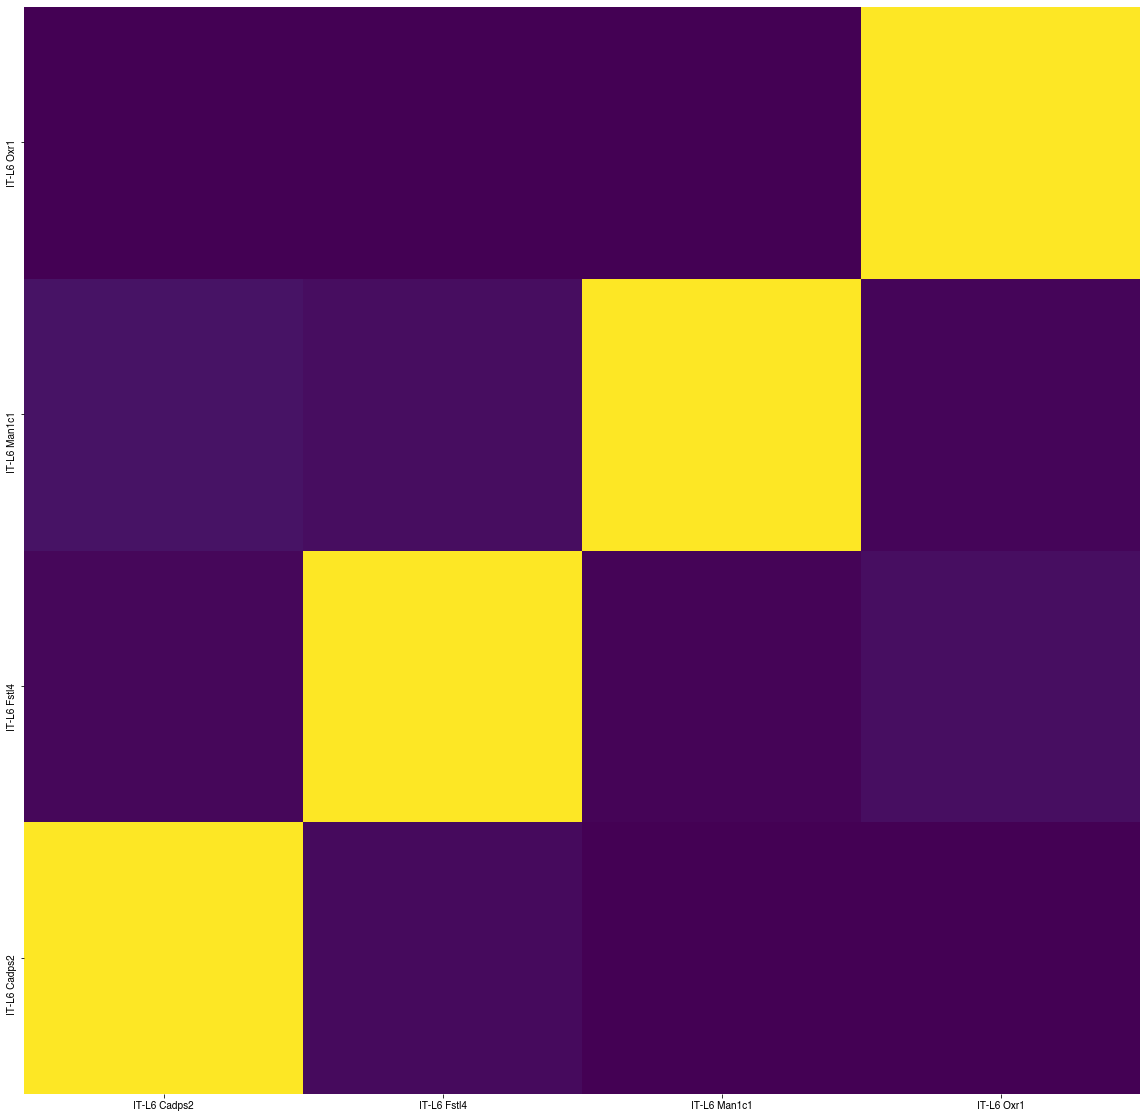

In [28]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [29]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

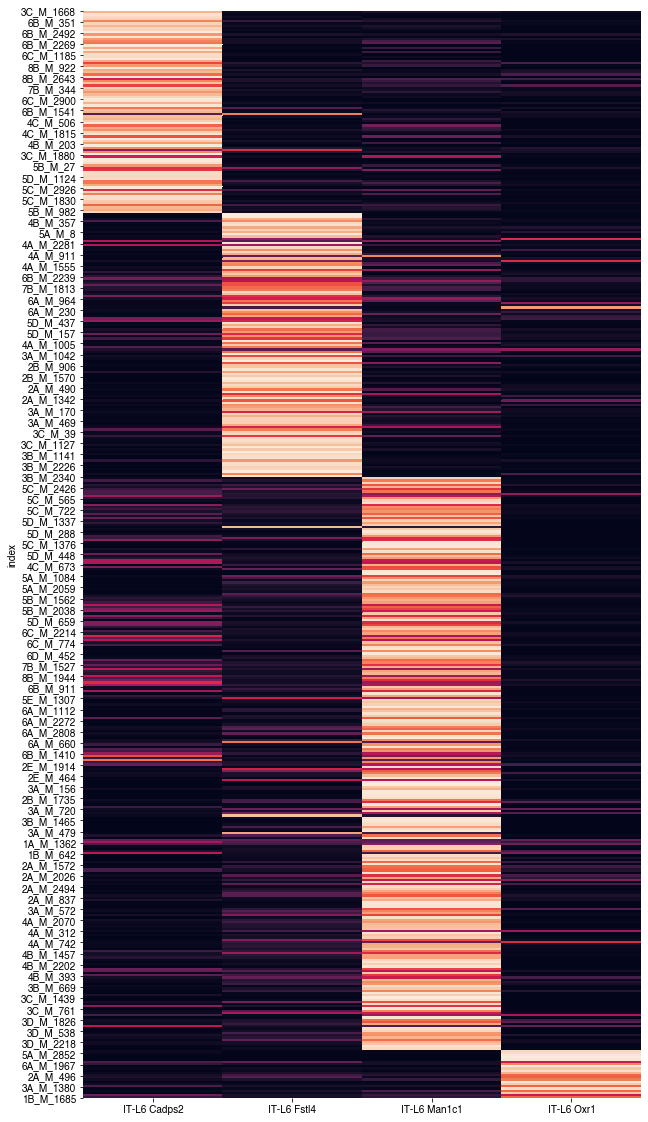

In [30]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

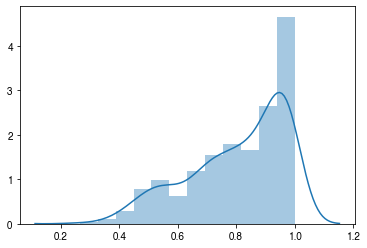

In [31]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [32]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')